In [161]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import psycopg2 # needed to get database exception errors when uploading dataframe
import requests # package for getting data from the web
from zipfile import * # package for unzipping zip files
from dotenv import load_dotenv
import os
import json
from sql_functions import get_engine
from sql_functions import get_dataframe
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
# defining the schema and assign the engine for connecting to the database

schema = 'cgn_analytics_24_1' 
engine = get_engine() 

In [129]:
# defining a function for the API call from rapidAPI for time period 17.01.23 - 15.02.23

def api_call(station_no, tz="America/Chicago"):
	load_dotenv()
	url = "https://meteostat.p.rapidapi.com/stations/hourly"
	querystring = {"station":station_no,"start":"2023-01-17","end":"2023-02-15","tz":tz}
	headers = {
	"X-RapidAPI-Key": os.getenv('rapidapi_key'),
	"X-RapidAPI-Host": "meteostat.p.rapidapi.com"}
	r = requests.get(url, headers=headers, params=querystring)
	json_object = json.loads(r.content)
	return r.json()



In [130]:
weather_json = api_call("74745")


In [131]:
# unpack your list of dicts (data column in your origin dataframe) to a dataframe (we don't need the meta generated column anyway)

weather_xxx = pd.DataFrame(weather_json['data'])

# naming convention: weather_{airport_code in lowercase}

In [132]:
# getting the weather data for the different airports

# Station Numbers:
# Memphis: "72334", Airport-Code: MEM
# Dallas: "72259" Airport-Code: DFW
# Dallas #2: "72258" Airport-Code: DAL
# Nashville: 72327", Airport-Code: BNA
# Austin: "74745", Airport-Code: AUS
# Oclahoma: "72353", Airport-Code: OKC
# San Antiono: "72253", Airport-Code: SAT


list_codes = ['DFW', 'AUS', 'DAL','SAT', 'OKC', 'MEM', 'BNA']

In [63]:
# import weather_table that already exists
# naming convention: weather_{airport_code in lowercase}

weather_bna = get_dataframe(f"Select * from {schema}.jlt_airport_bna;")
weather_dfw = get_dataframe(f"Select * from {schema}.jlt_airport_dfw;")
weather_mem = get_dataframe(f"Select * from {schema}.jlt_airport_mem;")
weather_sat = get_dataframe(f"Select * from {schema}.jlt_airport_sat;")
weather_dal = get_dataframe(f"Select * from {schema}.jlt_airport_dal;")
weather_aus = get_dataframe(f"Select * from {schema}.jlt_airport_aus;")
weather_okc = get_dataframe(f"Select * from {schema}.jlt_airport_okc;")

In [363]:
# drop columns in the weather dataframe that we don't need

column_l = ['wdir', 'tsun', 'dwpt', 'rhum', 'pres']
weather_l = [weather_bna,  weather_dfw, weather_mem, weather_sat, weather_dal, weather_aus, weather_okc]

def drop_weather_columns(df, column_l):
    df.drop(column_l, axis=1, inplace=True)

In [65]:
for i in weather_l:
     drop_weather_columns(i, column_l)

In [66]:
coco_dict = {1:'Clear', 
2: 'Fair', 
3:'Cloudy',
4: 'Overcast',
5: 'Fog',
6: 'Freezing Fog',
7: 'Light Rain',
8: 'Rain',
9: 'Heavy Rain',
10: 'Freezing Rain',
11: 'Heavy Freezing Rain',
12: 'Sleet',
13: 'Heavy Sleet',
14: 'Light Snowfall',
15: 'Snowfall',
16: 'Heavy Snowfall',
17: 'Rain Shower',
18: 'Heavy Rain Shower',
19: 'Sleet Shower',
20: 'Heavy Sleet Shower',
21: 'Snow Shower',
22: 'Heavy Snow Shower',
23: 'Lightning',
24: 'Hail',
25: 'Thunderstorm',
26: 'Heavy Thunderstorm',
27: 'Storm'}

# Assign values in the coco column by mapping the keys from type_acft column to the values in the coco_dict dictionary.
def assign_coco(df):
    df['weather_condition'] = df['coco'].map(coco_dict)

# Converting the time column to datetime for the merging later
def convert_time(df):
    df['time'] = pd.to_datetime(df['time'])

In [67]:
for i in weather_l:
    assign_coco(i)

for i in weather_l:
    convert_time(i)

In [69]:
def dif_condition(df):
    return df['weather_condition'].unique()

In [49]:
dif_condition(weather_bna)

array(['Heavy Rain', 'Rain', 'Light Rain', 'Overcast', 'Cloudy', 'Fair',
       'Fog', 'Clear'], dtype=object)

In [50]:
# Write records stored in a dataframe to SQL database

schema = 'cgn_analytics_24_1' 
engine = get_engine() 

def export_table(df, airport_code):
    # creating table_name with jlt_airport and the airport_code
    global engine
    table_name = f'jlt_airport_{airport_code}'
    if engine!=None:
        try:
            df.to_sql(name=table_name, # Name of SQL table
                    con=engine, # Engine or connection
                    if_exists='replace', # Drop the table before inserting new values 
                schema=schema, # Use schmea that was defined earlier
                    index=False, # Write DataFrame index as a column
                    chunksize=5000, # Specify the number of rows in each batch to be written at a time
                    method='multi') # Pass multiple values in a single INSERT clause
            print(f"The {table_name} table was imported successfully.")
    # Error handling
        except (Exception, psycopg2.DatabaseError) as error:
            print(error)
            engine = None

In [141]:
export_table(weather_xxx, 'xxx')

In [11]:
flights_df = get_dataframe(f"Select * from {schema}.jlt_flights WHERE flight_date < '2023-02-16 00:00:00.000' AND flight_date > '2023-01-16 00:00:00.000' ORDER BY flight_date ASC;")

In [12]:
# make a new column with timestamps for dep, sched_dep, arr and sched_arr (and columns that we are using for the merging later)

def convert_timestamp(df, column):
    df['hours'] = df[f'{column}'] // 100
    df['minutes'] = df[f'{column}'] % 100
    df[f'{column}stamp'] = df['flight_date'] + pd.to_timedelta(flights_df['hours'], unit='h') + \
                            pd.to_timedelta(flights_df['minutes'], unit='m')
    df[f'{column}stamp_merge'] = flights_df['flight_date'] + pd.to_timedelta(flights_df['hours'], unit='h')
    df.drop('hours', axis=1, inplace=True)
    df.drop('minutes', axis=1, inplace=True)

In [13]:
convert_timestamp(flights_df, 'dep_time')
convert_timestamp(flights_df, 'sched_dep_time')
convert_timestamp(flights_df, 'arr_time')
convert_timestamp(flights_df, 'sched_arr_time')

In [34]:
# copy of our origin table with less columns for a better overview
flights_df1 = flights_df.copy()
flights_df1 = flights_df1[['flight_date', 'origin', 'dep_timestamp', 'sched_dep_timestamp', 'dep_delay', 'dest', 'arr_timestamp',
       'sched_arr_timestamp', 'arr_delay','actual_elapsed_time', 'air_time' , 'airline', 'tail_number',
       'flight_number', 'distance', 'cancelled', 'diverted', 'cancel_code', 'carrier_delay',
       'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay', 'sched_dep_timestamp_merge', 'dep_timestamp_merge', 'sched_arr_timestamp_merge', 'arr_timestamp_merge']]

In [70]:
# creating separate dataframes for different airports for arrivals & departures

def airport_df(df, airport_code):
    # Merge on 'sched_dep_timestamp_merge' if origin=airport_code
    dep = df.copy()
    dep = dep.loc[df['origin'] == f'{airport_code}']
    merged_dep = pd.merge(dep,
                          eval(f'weather_{airport_code.lower()}'),
                          left_on='sched_dep_timestamp_merge',
                          right_on='time',
                          how='left')
    # Merge on 'sched_arr_timestamp_merge' if dest=airport_code
    arr = df.copy()
    arr = arr.loc[df['dest'] == f'{airport_code}']
    merged_arr = pd.merge(arr,
                          eval(f'weather_{airport_code.lower()}'),
                          left_on='sched_arr_timestamp_merge',
                          right_on='time',
                          how='left')
    return pd.concat([merged_dep, merged_arr], ignore_index=True)

In [71]:

merge_dfw = airport_df(flights_df1, 'DFW')
merge_aus = airport_df(flights_df1, 'AUS')
merge_dal = airport_df(flights_df1, 'DAL')
merge_sat = airport_df(flights_df1, 'SAT')
merge_okc = airport_df(flights_df1, 'OKC')
merge_mem = airport_df(flights_df1, 'MEM')
merge_bna = airport_df(flights_df1, 'BNA')

In [ ]:
# better overview

def display_less(df):
    return df[['flight_date', 'dep_timestamp', 'sched_dep_timestamp', 'dep_delay', 'dest',
       'arr_timestamp', 'sched_arr_timestamp', 'arr_delay','cancelled', 'diverted', 
       'weather_delay', 'time', 'temp', 'prcp', 'snow', 'wspd', 'wpgt',
       'weather_condition']]

In [72]:
# better overview + query for flights with a weather_delay

def query_weather_delay(df):
    return df[['flight_date', 'dep_timestamp', 'sched_dep_timestamp', 'dep_delay', 'dest',
       'arr_timestamp', 'sched_arr_timestamp', 'arr_delay','cancelled', 'diverted', 
       'weather_delay', 'time', 'temp', 'prcp', 'snow', 'wspd', 'wpgt',
       'weather_condition']].query('weather_delay > 0')


In [162]:
# define a function to plot canc. per day for each city

def plot_canc_day(df, city, airport_code):
    cancelled_flights_per_day = df.groupby("flight_date")['cancelled'].sum()
    plt.figure(figsize=(15, 6))
    ax = cancelled_flights_per_day.plot(kind='bar', color='skyblue', edgecolor='darkblue')
    ax.set_ylim(0,1200)
    plt.xlabel("Date")
    plt.ylabel("Number of Cancelled Flights")
    plt.title(f"Number of Cancelled Flights per Day in {city} ({airport_code})")
    ax.set_xticklabels(cancelled_flights_per_day.index.strftime('%Y-%m-%d'))
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

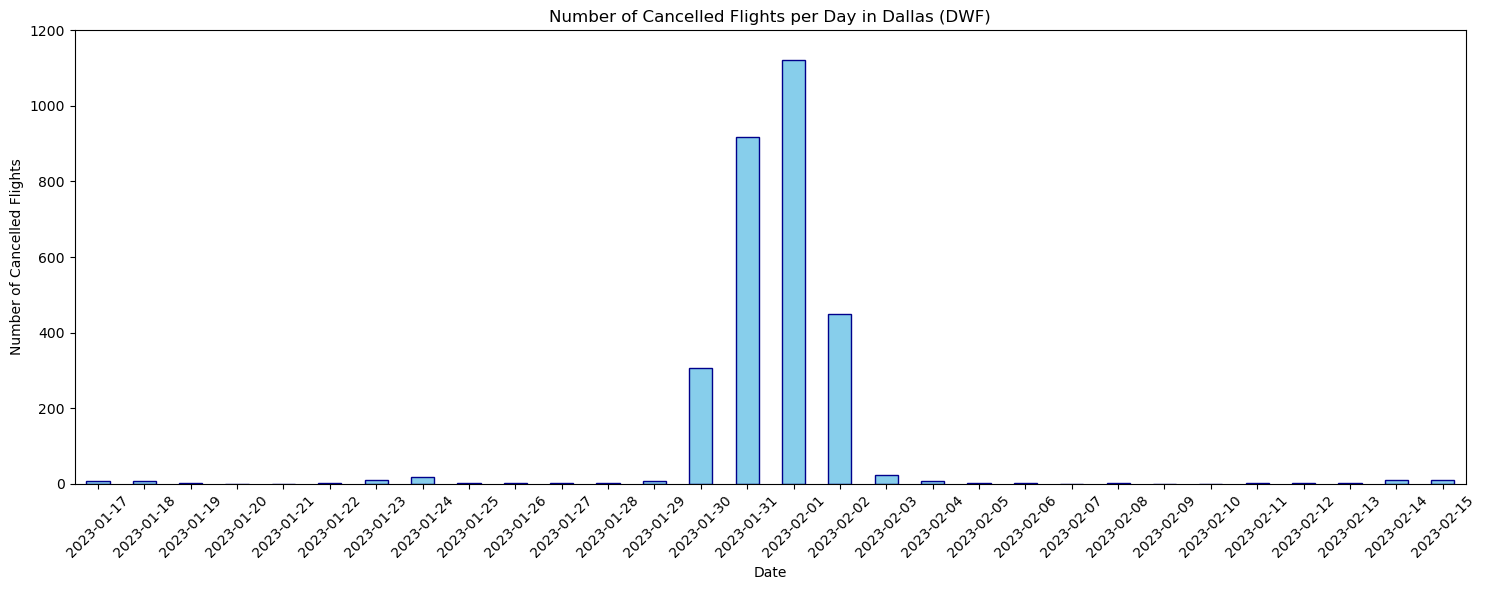

In [95]:
plot_canc_day(merge_dfw, 'Dallas', 'DWF')

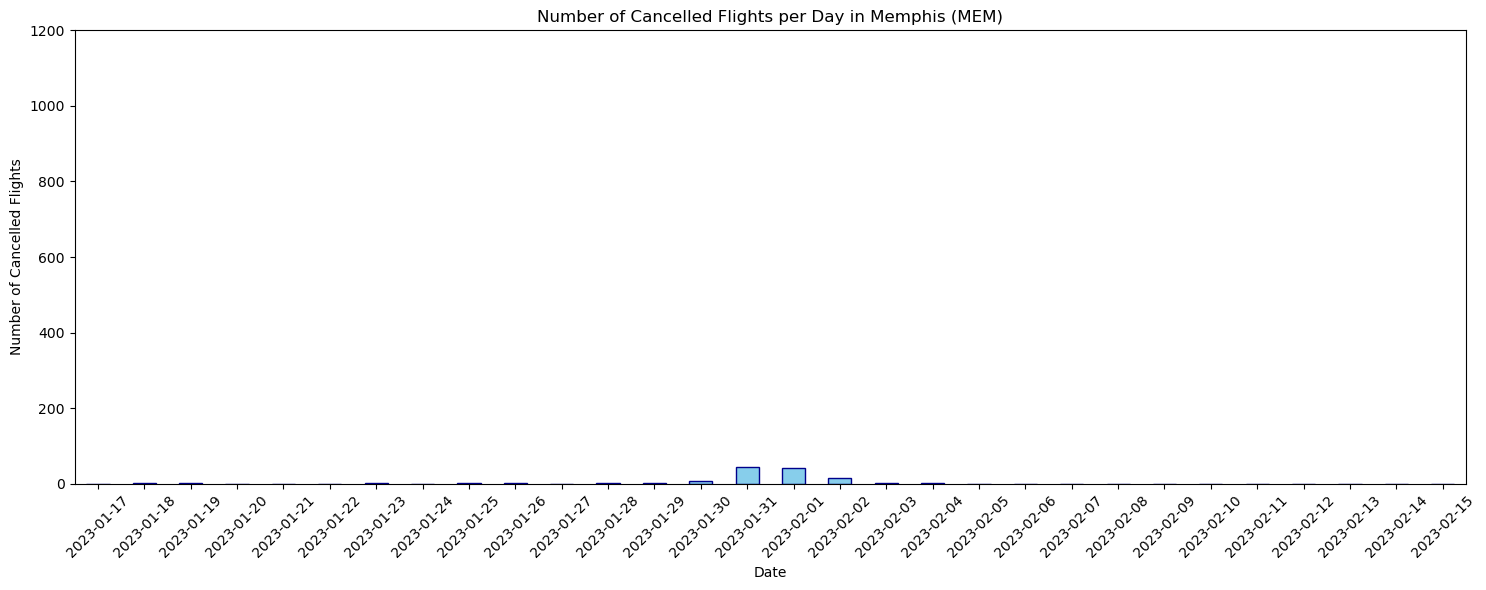

In [ ]:
plot_canc_day(merge_mem, 'Memphis', 'MEM')

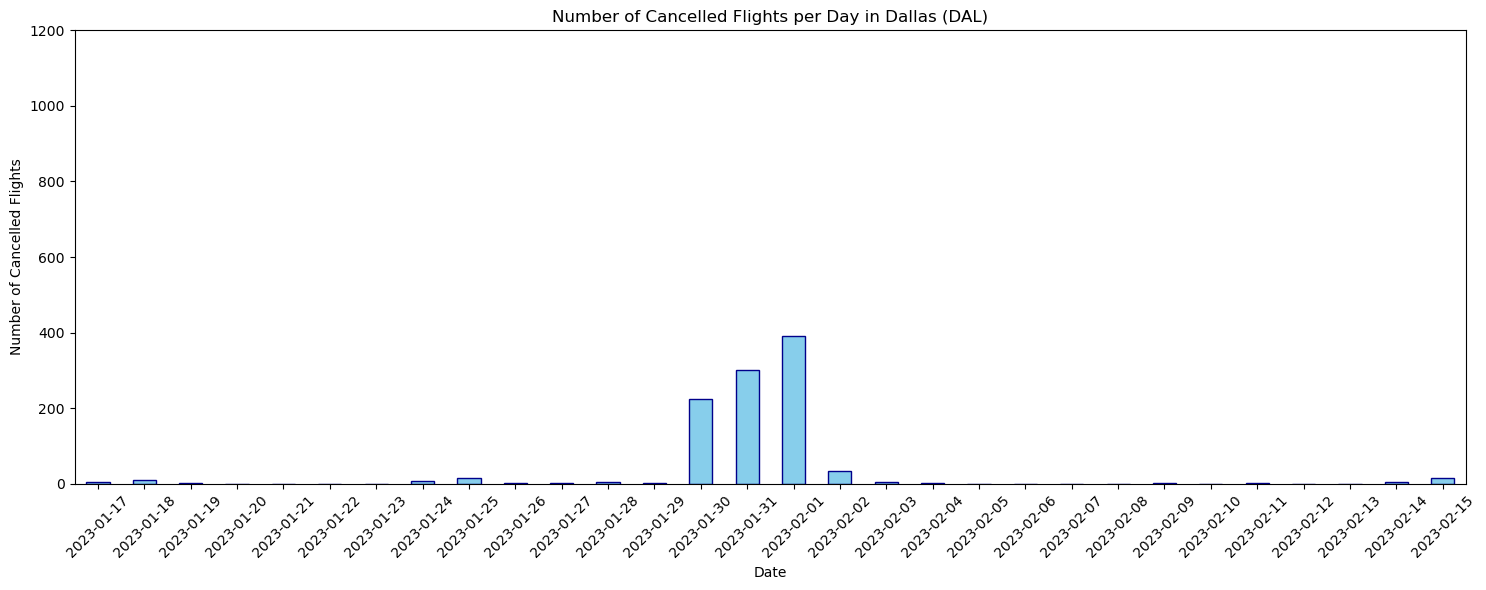

In [ ]:
plot_canc_day(merge_dal, 'Dallas', 'DAL')

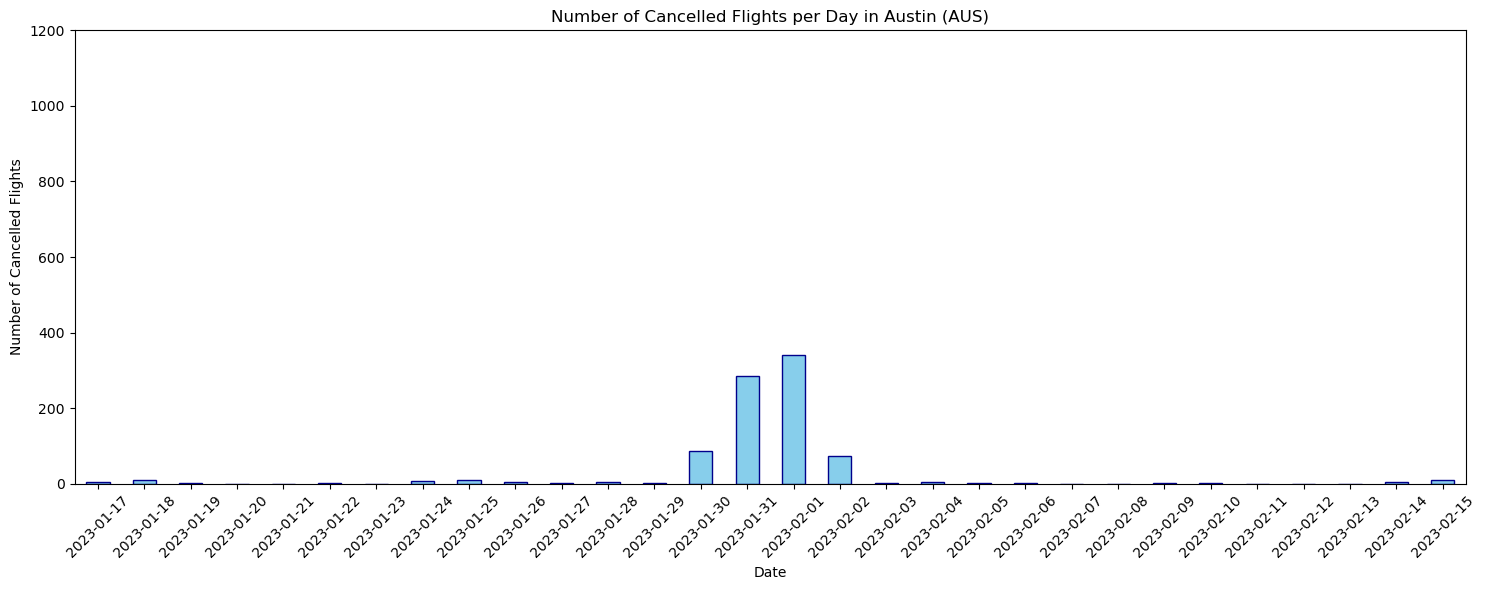

In [ ]:
plot_canc_day(merge_aus, 'Austin', 'AUS')

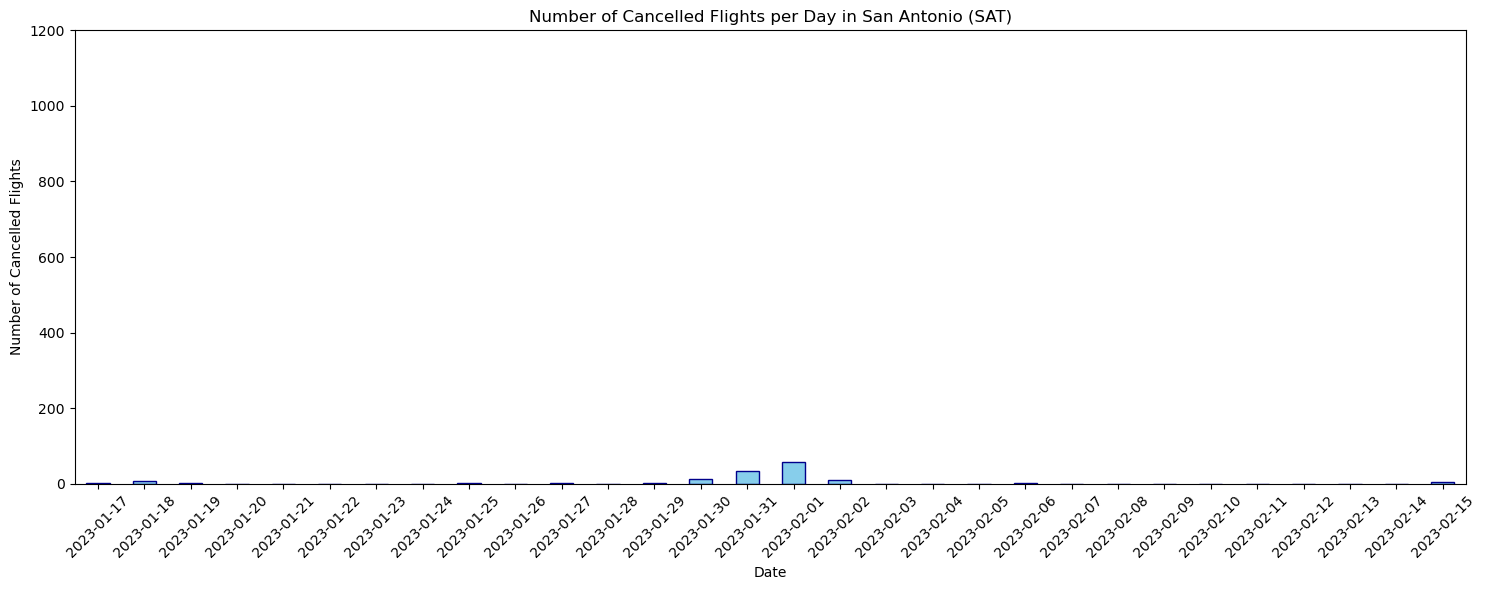

In [ ]:
plot_canc_day(merge_sat, 'San Antonio', 'SAT')

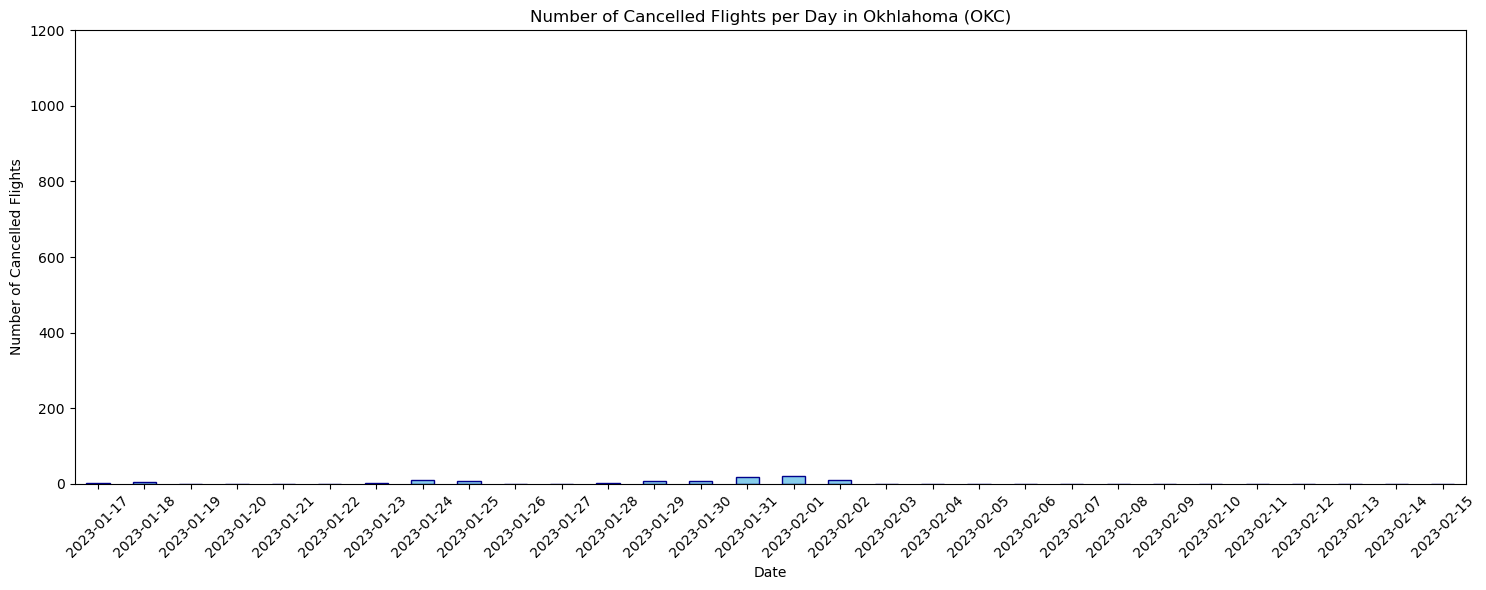

In [ ]:
plot_canc_day(merge_okc, 'Okhlahoma', 'OKC')

In [81]:
def delayed_col(df):
    delayed=[]
    for i in df['dep_delay']:
        if i >0:
            delayed.append(1)
        else:
            delayed.append(0)
    return delayed

In [82]:
df_list = [merge_aus, merge_bna, merge_dal, merge_dfw, merge_sat, merge_mem, merge_okc]

for i in df_list:     
    i['delayed'] = delayed_col(i)     

In [83]:
def plot_delayed(df, city, airport_code):
    delayed_flights_per_day = df.groupby("flight_date")['delayed'].sum()
    plt.figure(figsize=(15, 6))
    ax = delayed_flights_per_day.plot(kind='bar', color='red', edgecolor='darkred')
    ax.set_ylim(0,1000)
    plt.xlabel("Date")
    plt.ylabel("Number of delayed Flights")
    plt.title(f"Number of delayed Flights per Day in {city} ({airport_code})")
    ax.set_xticklabels(delayed_flights_per_day.index.strftime('%Y-%m-%d'))
    plt.xticks(rotation=45)  
    plt.tight_layout()  
    plt.show()

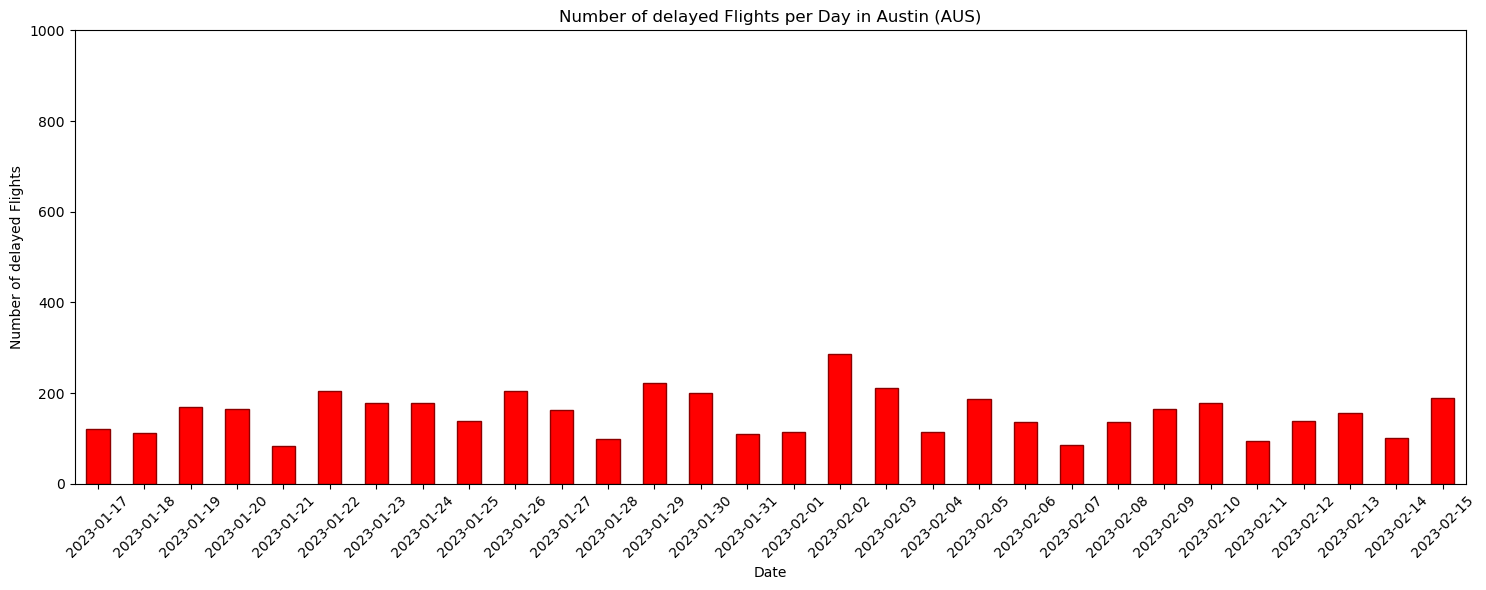

In [87]:
plot_delayed(merge_aus, "Austin", "AUS")

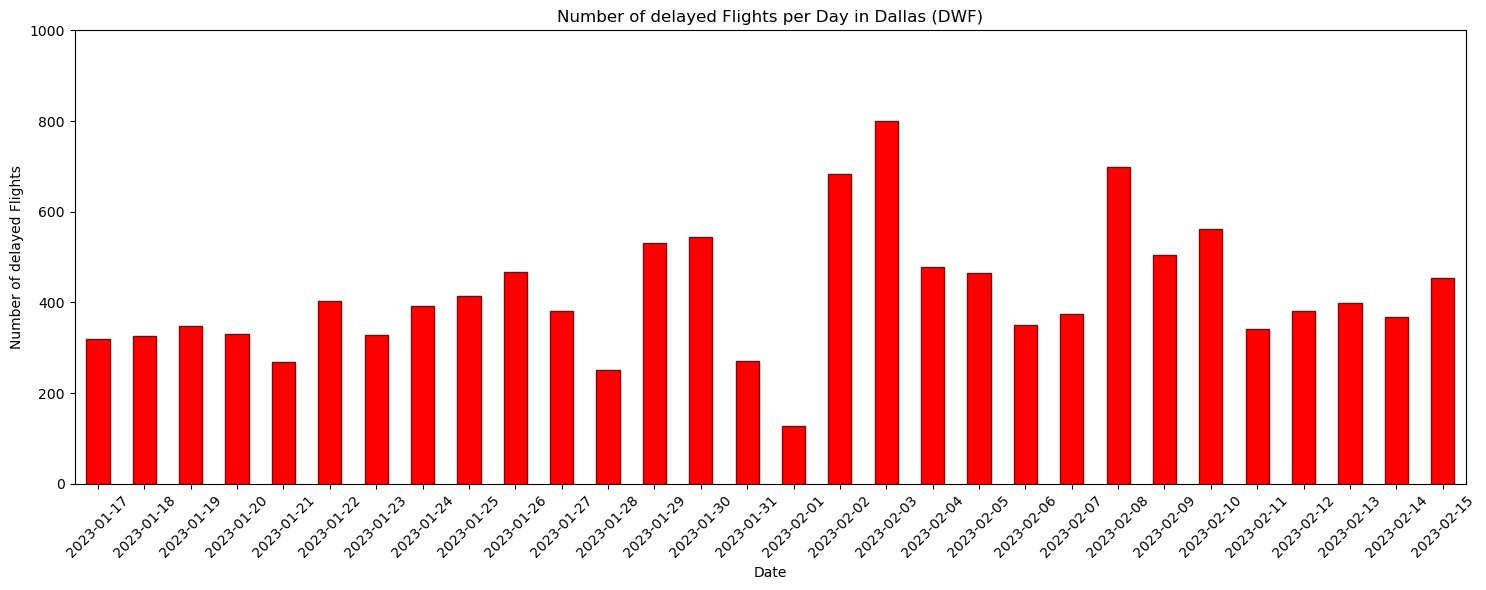

In [86]:
plot_delayed(merge_dfw, 'Dallas', 'DWF')

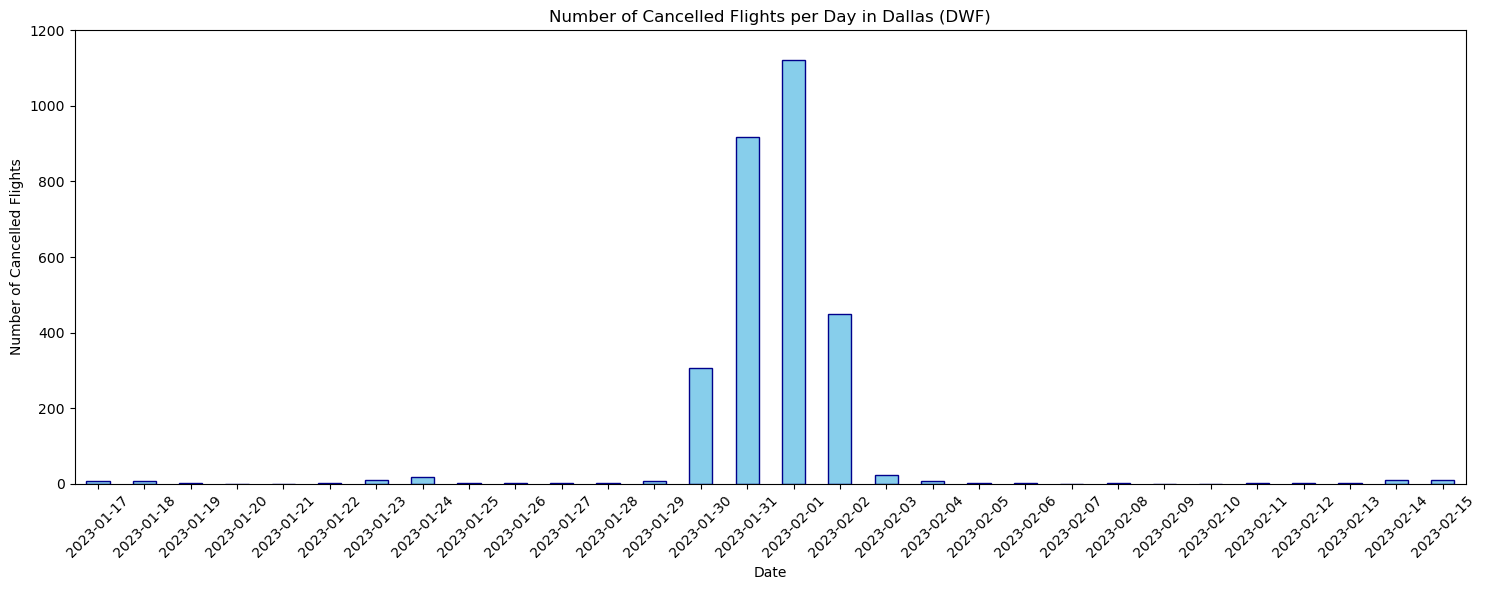

In [85]:
plot_canc_day(merge_dfw, 'Dallas', 'DWF')

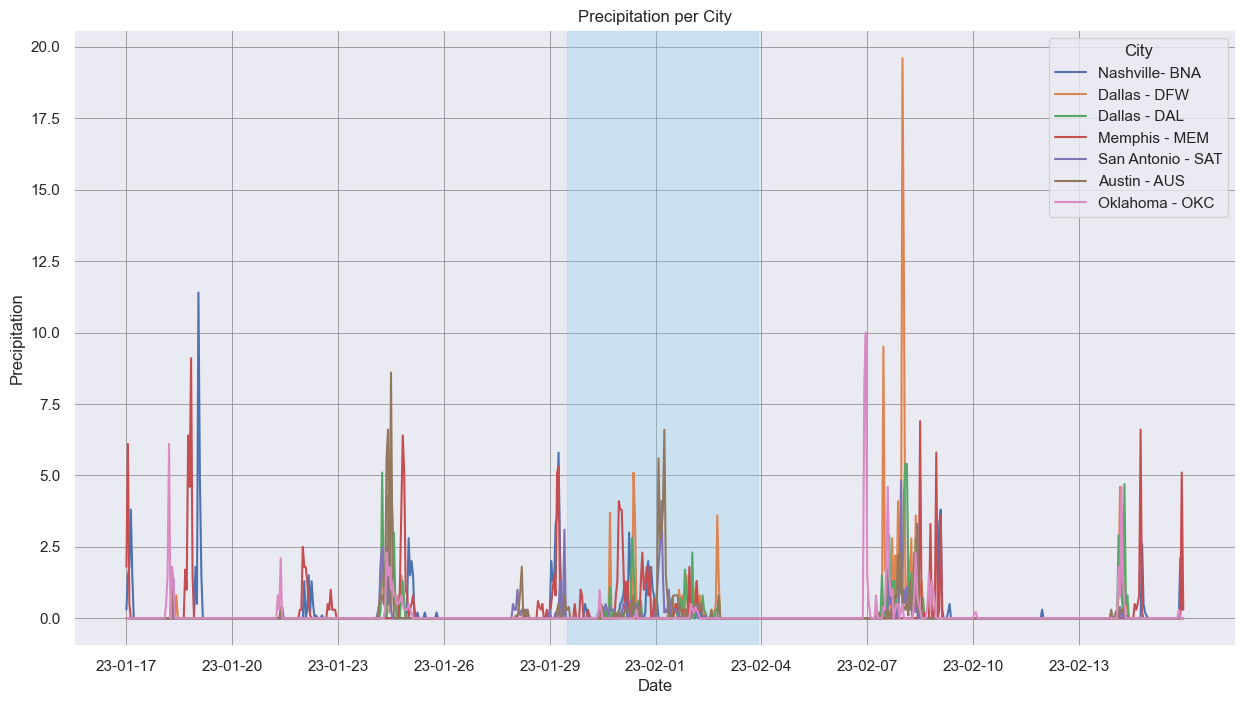

In [303]:
# create a seperate dataframe with temp. per day for each city

weather_l = [weather_bna,  weather_dfw, weather_dal, weather_mem, weather_sat,  weather_aus, weather_okc]
prcp_columns = []


for df in weather_l:
    prcp_columns.append(df['prcp'])

merged_df_prcp = pd.DataFrame(prcp_columns).T

merged_df_prcp.columns = ['Nashville- BNA', 'Dallas - DFW', 'Dallas - DAL','Memphis - MEM', 'San Antonio - SAT',  'Austin - AUS', 'Oklahoma - OKC']
start_date = '2023-01-17'
end_date = '2023-02-15'
date_range = pd.date_range(start='2023-01-17', end='2023-02-15', freq='3D')
date_strings = [date.strftime('%y-%m-%d') for date in date_range]

# Plot merged_df_daily 

plt.figure(figsize=(15, 8))
for city in merged_df_prcp.columns:
    plt.plot(merged_df_prcp.index, merged_df_prcp[city], label=city)

plt.title('Precipitation per City')
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.legend(title='City')

plt.xticks(ticks=(np.arange(0, 700, step=72)),  labels=date_strings)
highlight_start = 300
highlight_end = 430
plt.axvspan(highlight_start, highlight_end, color='skyblue', alpha=0.3)
plt.grid(True, color='gray', linestyle='-', linewidth=0.5)
plt.show()

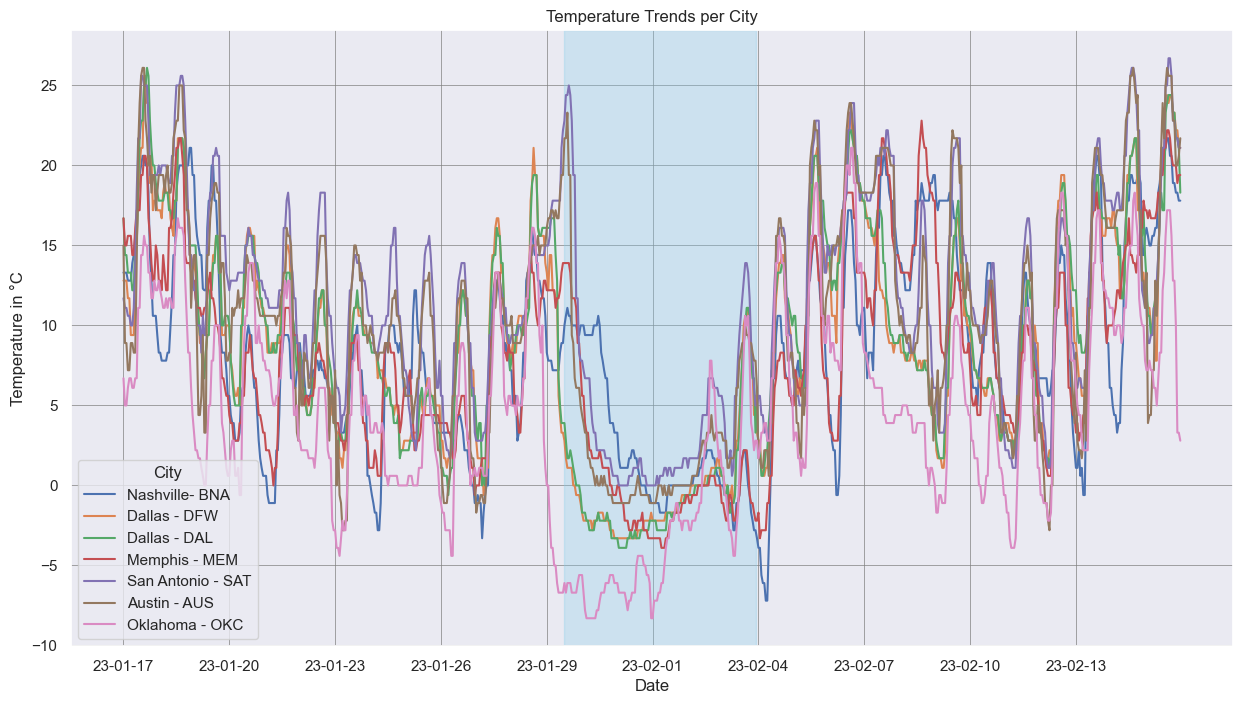

In [364]:
# create a seperate dataframe with temp. per day for each city

weather_l = [weather_bna,  weather_dfw, weather_dal, weather_mem, weather_sat,  weather_aus, weather_okc]
temp_columns = []


for df in weather_l:
    temp_columns.append(df['temp'])

merged_df_temp = pd.DataFrame(temp_columns).T

merged_df_temp.columns = ['Nashville- BNA', 'Dallas - DFW', 'Dallas - DAL','Memphis - MEM', 'San Antonio - SAT',  'Austin - AUS', 'Oklahoma - OKC']
start_date = '2023-01-17'
end_date = '2023-02-15'
date_range = pd.date_range(start='2023-01-17', end='2023-02-15', freq='3D')
date_strings = [date.strftime('%y-%m-%d') for date in date_range]

# Plot merged_df_daily 

plt.figure(figsize=(15, 8))
for city in merged_df_temp.columns:
    plt.plot(merged_df_temp.index, merged_df_temp[city], label=city)

plt.title('Temperature Trends per City')
plt.xlabel('Date')
plt.ylabel('Temperature in °C')
plt.legend(title='City')

plt.xticks(ticks=(np.arange(0, 700, step=72)),  labels=date_strings)
highlight_start = 300
highlight_end = 430
plt.axvspan(highlight_start, highlight_end, color='skyblue', alpha=0.3)
plt.grid(True, color='gray', linestyle='-', linewidth=0.5)

In [305]:
def cancelled_func(df):
    number_flights=df.groupby('flight_date')['flight_date'].count()
    cancelled=df.groupby('flight_date')['cancelled'].sum()
    ratio_cancelled=(cancelled/number_flights)*100
    return(ratio_cancelled)
    


In [306]:
ratio_cancelled_aus=cancelled_func(merge_aus)
ratio_cancelled_dal=cancelled_func(merge_dal)
ratio_cancelled_dfw=cancelled_func(merge_dfw)
ratio_cancelled_sat=cancelled_func(merge_sat)
ratio_cancelled_mem=cancelled_func(merge_mem)
ratio_cancelled_bna=cancelled_func(merge_bna)
ratio_cancelled_okc=cancelled_func(merge_okc)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py

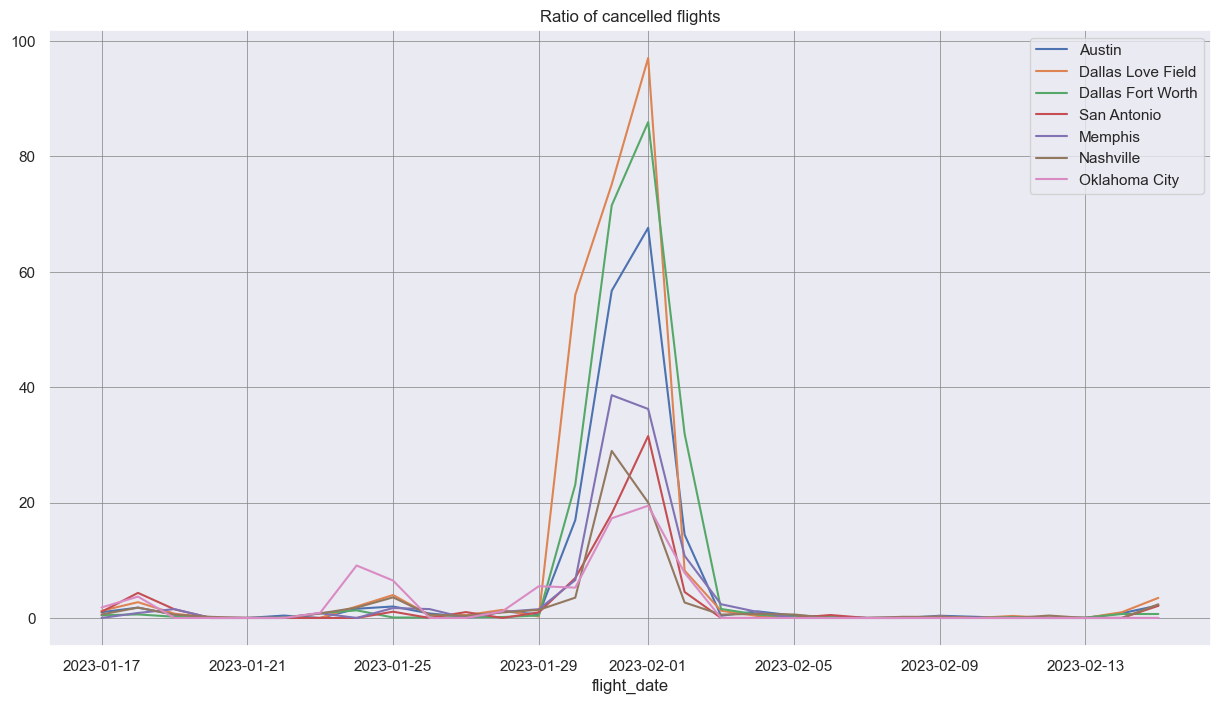

In [310]:

plt.figure(figsize=(15, 8))
sns.lineplot(data=ratio_cancelled_aus, label='Austin').set_title('Ratio of cancelled flights')
sns.lineplot(data=ratio_cancelled_dal, label='Dallas Love Field').set_title('Ratio of cancelled flights')
sns.lineplot(data=ratio_cancelled_dfw, label='Dallas Fort Worth').set_title('Ratio of cancelled flights')
sns.lineplot(data=ratio_cancelled_sat, label='San Antonio').set_title('Ratio of cancelled flights')
sns.lineplot(data=ratio_cancelled_mem, label='Memphis').set_title('Ratio of cancelled flights')
sns.lineplot(data=ratio_cancelled_bna, label='Nashville').set_title('Ratio of cancelled flights')
sns.lineplot(data=ratio_cancelled_okc, label='Oklahoma City').set_title('Ratio of cancelled flights')
plt.grid(True, color='gray', linestyle='-', linewidth=0.5)

In [318]:
def del_col(df):
    delayed_col=[]
    for i in df['dep_delay']:
        if i >0:
            delayed_col.append(1)
        else:
            delayed_col.append(0)
    df['delayed']=delayed_col
    return(df)

In [312]:
aus_d_df=del_col(merge_aus)
dal_d_df=del_col(merge_dal)
dfw_d_df=del_col(merge_dfw)
mem_d_df=del_col(merge_mem)
bna_d_df=del_col(merge_bna)
sat_d_df=del_col(merge_sat)
okc_d_df=del_col(merge_okc)

In [313]:
def delayed_func(df):
    number_flights=df.groupby('flight_date')['flight_date'].count()
    delayed=df.groupby('flight_date')['delayed'].sum()
    ratio_delayed=(delayed/number_flights)*100
    return(ratio_delayed)

In [314]:
ratio_delayed_aus=delayed_func(merge_aus)
ratio_delayed_dal=delayed_func(merge_dal)
ratio_delayed_dfw=delayed_func(merge_dfw)
ratio_delayed_sat=delayed_func(merge_sat)
ratio_delayed_mem=delayed_func(merge_mem)
ratio_delayed_bna=delayed_func(merge_bna)
ratio_delayed_okc=delayed_func(merge_okc)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py

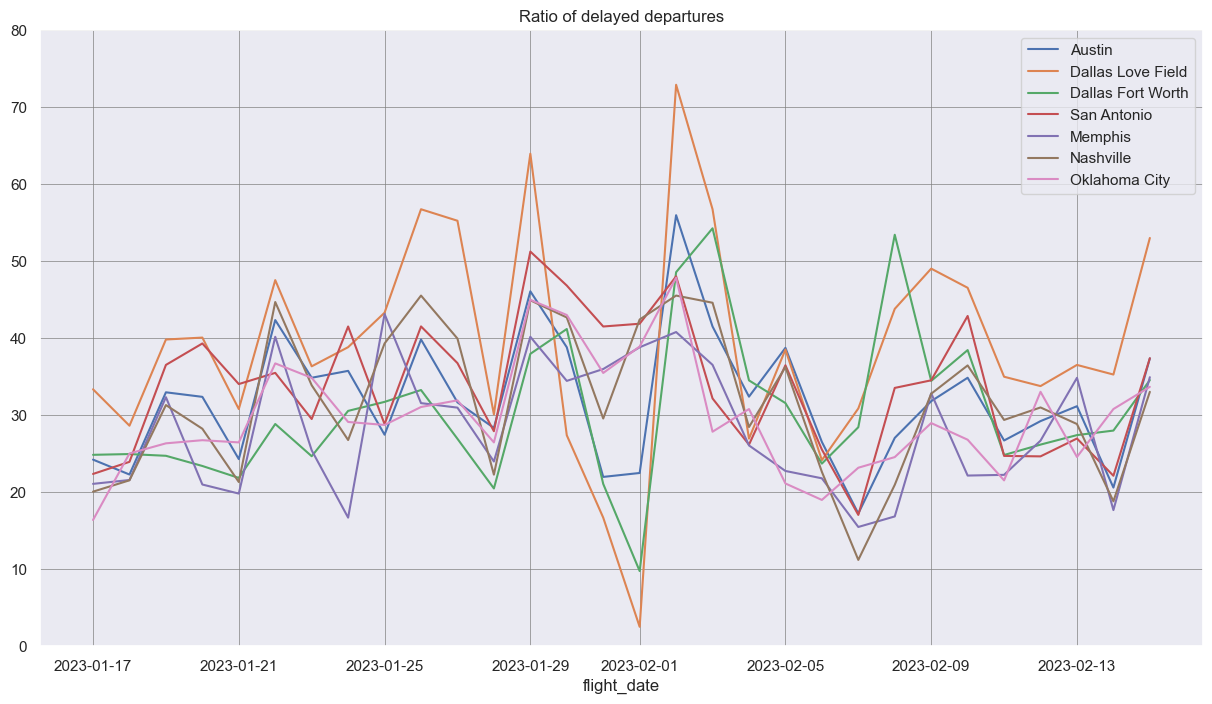

In [360]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=ratio_delayed_aus, label='Austin').set_title('Ratio of delayed departures')
sns.lineplot(data=ratio_delayed_dal, label='Dallas Love Field').set_title('Ratio of delayed departures')
sns.lineplot(data=ratio_delayed_dfw, label='Dallas Fort Worth').set_title('RRatio of delayed departures')
sns.lineplot(data=ratio_delayed_sat, label='San Antonio').set_title('Ratio of delayed departures')
sns.lineplot(data=ratio_delayed_mem, label='Memphis').set_title('Ratio of delayed departures')
sns.lineplot(data=ratio_delayed_bna, label='Nashville').set_title('Ratio of delayed departures')
sns.lineplot(data=ratio_delayed_okc, label='Oklahoma City').set_title('Ratio of delayed departures')
plt.ylim((0,80))
plt.grid(True, color='gray', linestyle='-', linewidth=0.5)

In [319]:
def wdel_col(df):
    wdelayed_col=[]
    for i in df['weather_delay']:
        if i >0:
            wdelayed_col.append(1)
        else:
            wdelayed_col.append(0)
    df['weather_delayed']=wdelayed_col
    return(df)

In [ ]:
# Thanks Param

In [317]:
#create a new table for each airport which includes the weather delayed column
aus_wd_df=wdel_col(merge_aus)
dal_wd_df=wdel_col(merge_dal)
dfw_wd_df=wdel_col(merge_dfw)
mem_wd_df=wdel_col(merge_mem)
bna_wd_df=wdel_col(merge_bna)
sat_wd_df=wdel_col(merge_sat)
okc_wd_df=wdel_col(merge_okc)

In [320]:
def wdelayed_func(df):
    number_flights=df.groupby('flight_date')['flight_date'].count()
    wdelayed=df.groupby('flight_date')['weather_delayed'].sum()
    ratio_wdelayed=(wdelayed/number_flights)*100
    return(ratio_wdelayed)

In [321]:
ratio_wdelayed_aus=wdelayed_func(aus_wd_df)
ratio_wdelayed_dal=wdelayed_func(dal_wd_df)
ratio_wdelayed_dfw=wdelayed_func(dfw_wd_df)
ratio_wdelayed_sat=wdelayed_func(sat_wd_df)
ratio_wdelayed_mem=wdelayed_func(mem_wd_df)
ratio_wdelayed_bna=wdelayed_func(bna_wd_df)
ratio_wdelayed_okc=wdelayed_func(okc_wd_df)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py

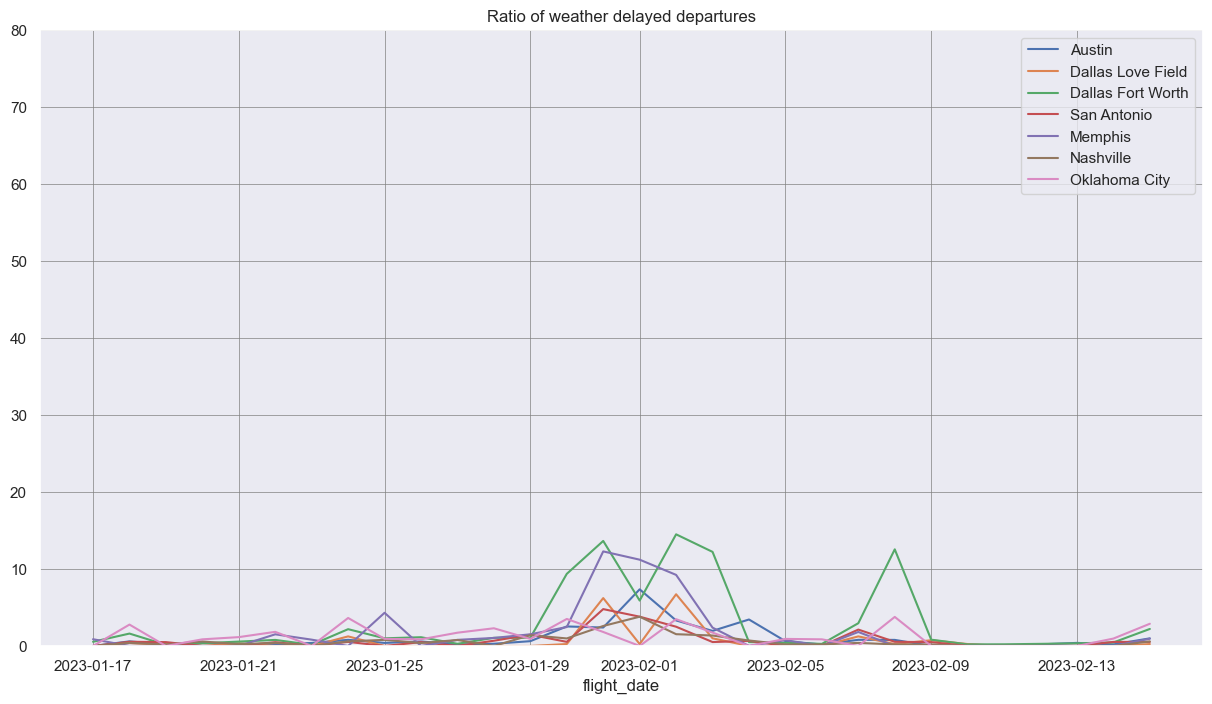

In [361]:

plt.figure(figsize=(15, 8))
sns.lineplot(data=ratio_wdelayed_aus, label='Austin').set_title('Ratio of weather delayed departures')
sns.lineplot(data=ratio_wdelayed_dal, label='Dallas Love Field').set_title('Ratio of weather delayed departures')
sns.lineplot(data=ratio_wdelayed_dfw, label='Dallas Fort Worth').set_title('RRatio of weather delayed departures')
sns.lineplot(data=ratio_wdelayed_sat, label='San Antonio').set_title('Ratio of weather delayed departures')
sns.lineplot(data=ratio_wdelayed_mem, label='Memphis').set_title('Ratio of weather delayed departures')
sns.lineplot(data=ratio_wdelayed_bna, label='Nashville').set_title('Ratio of weather delayed departures')
sns.lineplot(data=ratio_wdelayed_okc, label='Oklahoma City').set_title('Ratio of weather delayed departures')
plt.ylim((0,80))
plt.grid(True, color='gray', linestyle='-', linewidth=0.5)



In [345]:
temp_can_corr=merge_dfw[["cancelled", "temp"]]
temp_can_corr.head(10)

,cancelled,temp
0,0,20.0
1,0,18.3
2,0,21.1
3,0,23.9
4,0,25.6
5,0,20.6
6,0,25.0
7,0,20.6
8,0,17.2
9,0,21.1


In [346]:
temp_can_corr.corr()

,cancelled,temp
cancelled,1.000000,-0.432086
temp,-0.432086,1.000000


In [343]:
wind_can_corr=merge_dfw[["cancelled", "wspd"]]
wind_can_corr.head(10)

,cancelled,wspd
0,0,14.8
1,0,13.0
2,0,9.4
3,0,7.6
4,0,7.6
5,0,25.9
6,0,7.6
7,0,25.9
8,0,13.0
9,0,9.4


In [344]:
wind_can_corr.corr()

,cancelled,wspd
cancelled,1.000000,-0.023207
wspd,-0.023207,1.000000


In [350]:
weather_can_corr=merge_dfw[["cancelled", "coco"]]

weather_can_corr.head(10)

,cancelled,coco
0,0,3
1,0,3
2,0,3
3,0,4
4,0,4
5,0,4
6,0,3
7,0,4
8,0,3
9,0,3


In [351]:
weather_can_corr.corr()

,cancelled,coco
cancelled,1.000000,0.549861
coco,0.549861,1.000000


In [336]:
#percentage of weather delayed departures of flights that were not cancelled
not_cancelled_aus=aus_wd_df[aus_wd_df['cancelled']==0] # create a subset which only includes flights that were not cancelled
not_cancelled_dal=dal_wd_df[dal_wd_df['cancelled']==0] # create a subset which only includes flights that were not cancelled
not_cancelled_dfw=dfw_wd_df[dfw_wd_df['cancelled']==0] # create a subset which only includes flights that were not cancelled
not_cancelled_sat=sat_wd_df[sat_wd_df['cancelled']==0] # create a subset which only includes flights that were not cancelled
not_cancelled_mem=mem_wd_df[mem_wd_df['cancelled']==0] # create a subset which only includes flights that were not cancelled
not_cancelled_bna=bna_wd_df[bna_wd_df['cancelled']==0] # create a subset which only includes flights that were not cancelled
not_cancelled_okc=okc_wd_df[okc_wd_df['cancelled']==0] # create a subset which only includes flights that were not cancelled

In [352]:
def wdelayed_func(df):
    number_flights=df.groupby('flight_date')['flight_date'].count()
    wdelayed=df.groupby('flight_date')['weather_delayed'].sum()
    ratio_delayed=(wdelayed/number_flights)*100
    return(ratio_delayed)

In [353]:
ratio_wdelayed_ausc=wdelayed_func(not_cancelled_aus)
ratio_wdelayed_dalc=wdelayed_func(not_cancelled_dal)
ratio_wdelayed_dfwc=wdelayed_func(not_cancelled_dfw)
ratio_wdelayed_satc=wdelayed_func(not_cancelled_sat)
ratio_wdelayed_memc=wdelayed_func(not_cancelled_mem)
ratio_wdelayed_bnac=wdelayed_func(not_cancelled_bna)
ratio_wdelayed_okcc=wdelayed_func(not_cancelled_okc)

/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniconda/base/envs/nf_sql/lib/python3.9/site-packages/seaborn/_oldcore.py

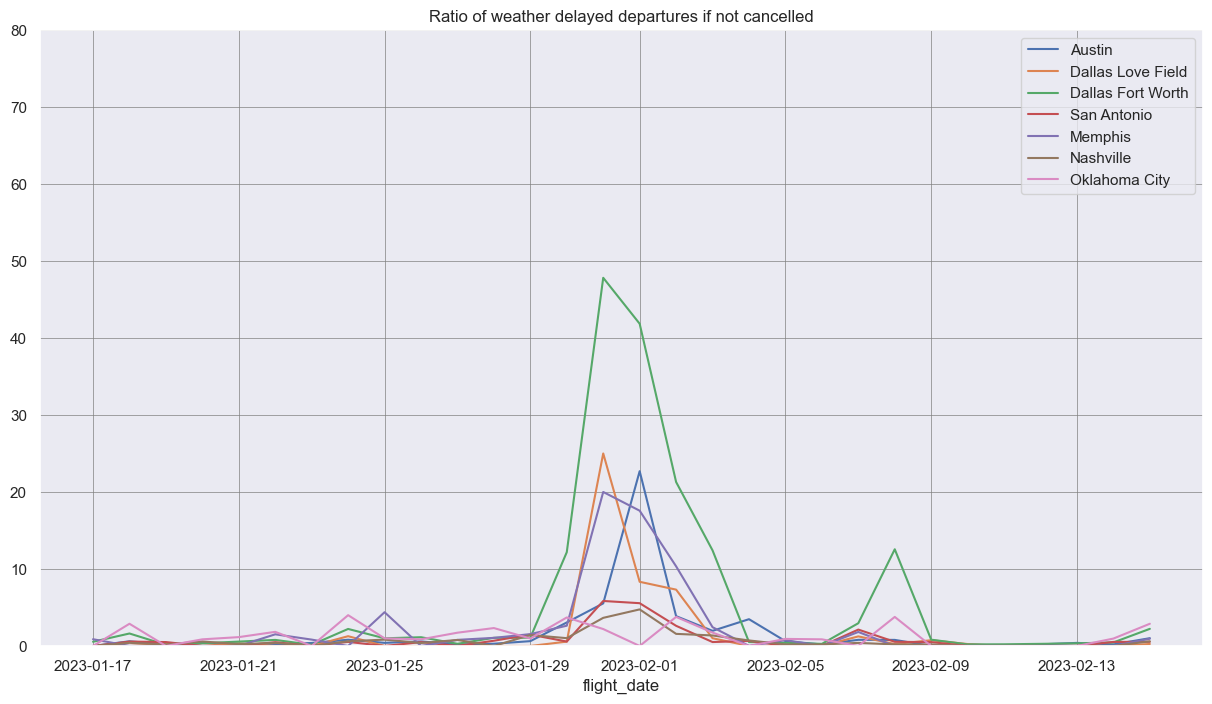

In [362]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=ratio_wdelayed_ausc, label='Austin').set_title('Ratio of weather delayed departures if not cancelled')
sns.lineplot(data=ratio_wdelayed_dalc, label='Dallas Love Field').set_title('Ratio of weather delayed departures if not cancelled')
sns.lineplot(data=ratio_wdelayed_dfwc, label='Dallas Fort Worth').set_title('RRatio of weather delayed departures if not cancelled')
sns.lineplot(data=ratio_wdelayed_satc, label='San Antonio').set_title('Ratio of weather delayed departures if not cancelled')
sns.lineplot(data=ratio_wdelayed_memc, label='Memphis').set_title('Ratio of weather delayed departures if not cancelled')
sns.lineplot(data=ratio_wdelayed_bnac, label='Nashville').set_title('Ratio of weather delayed departures if not cancelled')
sns.lineplot(data=ratio_wdelayed_okcc, label='Oklahoma City').set_title('Ratio of weather delayed departures if not cancelled')
plt.ylim((0,80))
plt.grid(True, color='gray', linestyle='-', linewidth=0.5)

In [365]:
merge_list = [merge_dal, merge_aus, merge_bna, merge_dfw, merge_mem, merge_okc, merge_sat]
all_airports_concat = pd.concat(merge_list)

In [367]:
cancelled_all=all_airports_concat.groupby(['flight_date','weather_condition'])['cancelled'].sum().sort_values() 
cancelled_all.tail(25)

flight_date  weather_condition  
2023-01-31   Overcast                36
2023-02-02   Sleet                   39
2023-02-01   Rain                    40
             Light Snowfall          47
             Heavy Snowfall          48
             Overcast                54
2023-02-02   Light Rain              63
2023-01-30   Rain                    74
2023-01-31   Light Rain              86
             Snowfall               109
2023-01-30   Fog                    132
2023-01-31   Sleet                  151
2023-02-01   Fog                    158
2023-01-31   Fog                    160
2023-01-30   Cloudy                 161
             Overcast               196
2023-02-01   Freezing Rain          227
2023-01-31   Cloudy                 246
2023-02-01   Snowfall               309
             Cloudy                 361
2023-02-02   Freezing Rain          373
2023-02-01   Light Rain             376
2023-01-31   Freezing Rain          412
2023-02-01   Heavy Freezing Rain    451
2023-01